In [1]:
from moredata.datasets import get_path
import pandas as pd

df = pd.read_csv(get_path("airbnb-berlin"))
df = df.loc[(~df['latitude'].isna()) & (~df['longitude'].isna())]
df.to_json('./data/airbnb-berlin.json', orient='records')

/home/gegen07/anaconda3/envs/moredata-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,22,36,41,45,46,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
from moredata.utils import geodesic_point_buffer
import json
from shapely.geometry import Polygon

with open('./data/airbnb-berlin.json') as f:
    data = json.loads(f.read())
    counter = 0
    for d in data:
        shp = Polygon(geodesic_point_buffer(d["latitude"], d["longitude"], 500)) # 0.785 km^2 of area
        d["area_point"] = shp.wkt
    with open("./data/airbnb-berlin-enriched-0.json", 'w') as outfile:
        json.dump(data, outfile, ensure_ascii=False)

In [3]:
import pandas as pd
import numpy as np
import json
from json import JSONDecodeError
import re

tourism = pd.read_csv('./data/tourism.csv.gz', index_col=0)
for index, x in tourism.iterrows():
    if not type(x['tags']) is float:

        j = re.sub(r'(?<=[\w])[\'\"](?=[\w])',"\\'", x['tags']).replace('\'', '\"')
        j = re.sub("(\"[\s\w]*)\"([\s\w-]*\")\"", r"\1\2", j)
        j = re.sub("\"(\"[\s\w]*)\"([\s\w]*)", r"\1\2", j)
        j = re.sub("\"([\s\w+,]*)([\s\w]*\")\"", r"\1\2", j)
        j = re.sub("\"([\s\w]*)\"([\s\w]*)\"", r'"\1\2"', j)
        j = re.sub("\"([\s\w]*)\"([\s\w.]*)([.\"])", r'"\1\2\3', j)
        try:
            j = json.loads(j)
            tourism.loc[index, 'value'] = j['tourism']
        except JSONDecodeError as e:
            tourism.loc[index, 'value'] = np.nan

/home/gegen07/anaconda3/envs/moredata-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,254,255,25

In [5]:
tourism['value'].value_counts()

information       2083
artwork           1365
hotel              670
museum             215
attraction         198
gallery            193
viewpoint          171
hostel             114
guest_house        109
picnic_site         91
zoo                 36
apartment           34
camp_site           13
chalet              13
caravan_site        11
theme_park           8
yes                  7
motel                5
aquarium             2
spa_resort           2
sightseeing          1
highlight            1
tower_viewer         1
day_spa              1
lean_to              1
wilderness_hut       1
luggage              1
history              1
Name: value, dtype: int64

In [4]:
names = tourism['value'].value_counts()[:5].index.tolist()
for x in names:
    tourism.loc[tourism['value']==x].to_csv(f'./data/places/{x}.csv.gz', compression='gzip', index=False)

In [6]:
DATA_SAVE_DIR = '/media/gegen07/0CE9-F585/datasets/moredata/functionalregion/'
## The functional region connector use the tourism.csv.gz downloaded from osm_downloader.ipynb
import moredata
from glob import glob
import os

places_files = glob('./data/places/*.csv.gz')

data = moredata.models.Data(data_file='./data/airbnb-berlin-enriched-0.json',
                            parser_func=moredata.parser.parse_document,
                            data_type='json')

for p in places_files:
    key_name = os.path.basename(p).split('.')[0]
    connector = moredata.enricher.osm.FunctionalRegionConnector(files=[p],
                                                                key=key_name)
    data_enriched = connector.enrich(data)
    moredata.utils.write_json_generator_to_json(DATA_SAVE_DIR+key_name, data_enriched, 100000)
    data = moredata.models.Data(data_file=DATA_SAVE_DIR+key_name+"-0.json",
                            parser_func=moredata.parser.parse_document,
                            data_type='json')

/home/gegen07/dev/nesped/more-data/moredata/enricher/osm/functional_region_connector.py:83: DtypeWarning: Columns (12,17,28,33,37,41,47,48,50,51,75,78,92,93,94,96,97,98,99,100,113,114,115,123,128,129,134,138,142,149,155,156,171,172,175,176,181,188,194,195,202,207,208,209,212,213,214,215,216,217,218,220,224,225,226,229,242,244,247,250,251,254,257,259,260,261,265,279,281,312,313,314,315,322,323,324,329,330,332,335,345,352,360,363,364,369,381,384,385,387,417,467,479,480) have mixed types.Specify dtype option on import or set low_memory=False.
  self._get_polygons()
/home/gegen07/dev/nesped/more-data/moredata/enricher/osm/functional_region_connector.py:83: DtypeWarning: Columns (5,6,7,15,18,21,23,24,25,28,32,37,38,41,46,51,52,53,63,91,105,106,107,109,110,111,112,113,122,125,130,131,139,143,150,151,156,163,165,169,172,175,177,178,179,181,190,192,193,204,213,220,224,225,227,237,238,239,240,241,245,254,293,294,302,304,311,314,317,318,319,326,328,330,333,334,336,337,343,344,347,348,381,384,387

In [7]:
df = pd.read_json(DATA_SAVE_DIR+'information-0.json', orient='records')
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,area_point,artwork,museum,hotel,attraction,information
0,1944,https://www.airbnb.com/rooms/1944,2.021031e+13,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,1.0,2.0,0.0,0.20,"POLYGON ((13.40486006221988 52.54424977059423,...",0,0,1,0,5
1,2015,https://www.airbnb.com/rooms/2015,2.021031e+13,2021-03-20,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,...,6.0,0.0,0.0,2.24,"POLYGON ((13.40992843638525 52.53453977067424,...",2,2,5,0,3
2,3176,https://www.airbnb.com/rooms/3176,2.021031e+13,2021-03-15,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,https://www.airbnb.com/users/show/3718,...,1.0,0.0,0.0,1.03,"POLYGON ((13.42494851338628 52.53499977067045,...",0,1,4,2,5
3,3309,https://www.airbnb.com/rooms/3309,2.021031e+13,2021-03-14,BerlinSpot Schöneberg near KaDeWe,First of all:<br />I prefer short-notice booki...,"My flat is in the middle of West-Berlin, direc...",https://a0.muscache.com/pictures/29054294/b1fa...,4108,https://www.airbnb.com/users/show/4108,...,0.0,1.0,0.0,0.29,"POLYGON ((13.35642246847334 52.49884977096802,...",5,0,25,0,0
4,6883,https://www.airbnb.com/rooms/6883,2.021031e+13,2021-03-20,Stylish East Side Loft in Center with AC & 2 b...,This apartment is available for people working...,The emerging and upcoming East of the new hip ...,https://a0.muscache.com/pictures/06b77d9b-4843...,16149,https://www.airbnb.com/users/show/16149,...,1.0,0.0,0.0,1.00,"POLYGON ((13.46213461741426 52.51170977086222,...",7,0,10,1,13


<ipython-input-8-f41ca8119f38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['price'] = plot_df['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))


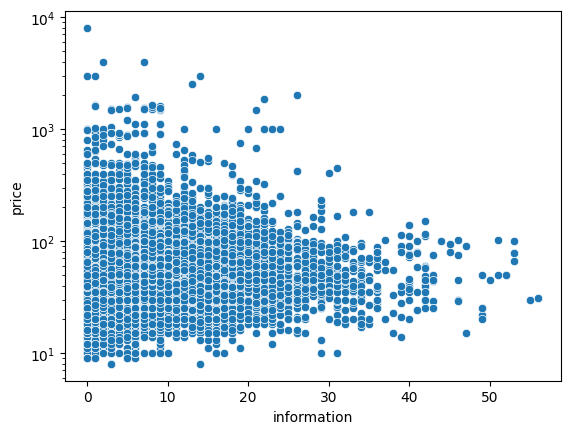

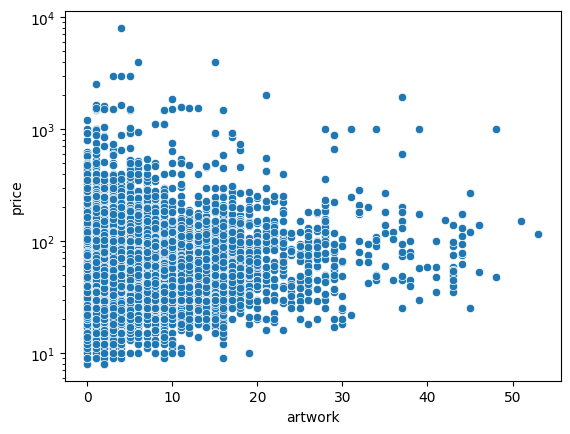

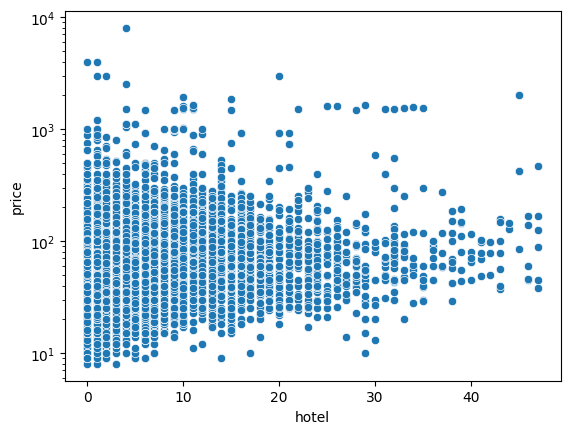

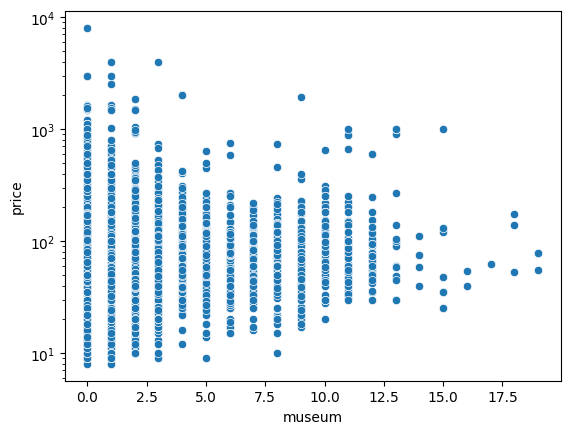

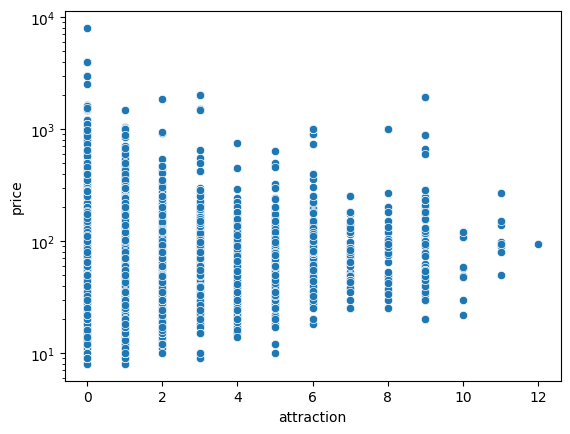

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = df[['price', 'artwork', 'hotel', 'museum', 'information', 'attraction']]
plot_df['price'] = plot_df['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
for n in names:
    sns.scatterplot(x=n, y='price', data=plot_df)
    plt.yscale('log')
    plt.show()

In [12]:
plot_df['total'] = df[['artwork', 'hotel', 'museum', 'information', 'attraction']].sum(axis=1)

<ipython-input-12-0961e6d35930>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['total'] = df[['artwork', 'hotel', 'museum', 'information', 'attraction']].sum(axis=1)


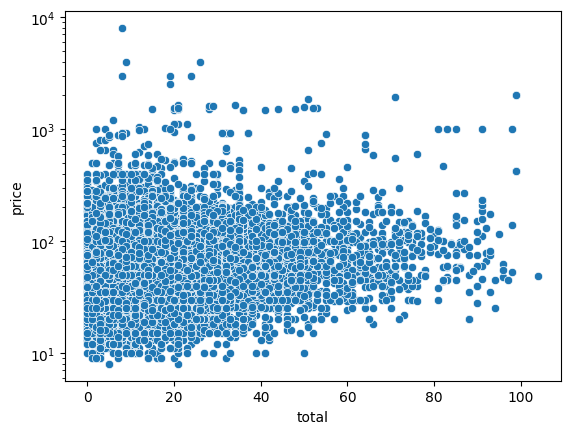

In [15]:
sns.scatterplot(x='total', y='price', data=plot_df)
plt.yscale('log')
plt.show()